In [2]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import itertools
import sys
from torchvision.utils import save_image, make_grid
from torchvision.models import vgg19

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class Setup:
    def __init__(self):
        self.epoch = 0
        self.n_epochs= 200
        self.dataset_name = "ksdakf"
        self.batch_size = 8
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.decay_epoch = 100
        self.n_cpu = 8
        self.hr_height = 256
        self.hr_width = 256
        self.channels = 3
        self.sample_interval = 100
        self.checkpoint_interval = 100
        self.training_image_dir  = 'data/train'
        self.validation_image_dir = 'data/validation'
        self.model_checkpoint_dir = 'model/checkpoints/SRCNN'
        self.results = 'data/results/SRCNN'
        self.validation_batch_size = 8
        


opt = Setup()

class ImageDataset(Dataset):
    def __init__(self, root, hr_shape, lr_factor):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // lr_factor, hr_height // lr_factor), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.png"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

train_set = ImageDataset(opt.training_image_dir,(opt.hr_height,opt.hr_width),2)

train_loader = DataLoader(
    train_set,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0)

validation_set = ImageDataset(opt.validation_image_dir,(opt.hr_height,opt.hr_width),2)

validation_loader = DataLoader(
    validation_set,
    batch_size=opt.validation_batch_size,
    shuffle=False,
    num_workers=0)



In [7]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))

In [17]:

cuda = torch.cuda.is_available()

hr_shape = (opt.hr_height, opt.hr_width)

bicubic_upscaler = transforms.Resize((opt.hr_width, opt.hr_height), Image.BICUBIC)
srcnn = SRCNN(3)
# Losses
criterion_loss = torch.nn.MSELoss()

if cuda:
    srcnn = srcnn.cuda()
    criterion_loss = criterion_loss.cuda()

if opt.epoch != 0:
    # Load pretrained models
    srcnn.load_state_dict(torch.load(opt.model_checkpoint_dir + "/srcnn_%d.pth"))

# Optimizers
optimizer = torch.optim.Adam(srcnn.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

train_psnr_log = []
train_loss_log = []
valid_psnr_log = []
valid_loss_log = []

# ----------
#  Training
# ----------

for epoch in range(opt.epoch, opt.n_epochs):
    avg_loss = 0
    avg_psnr = 0
    for i, imgs in enumerate(train_loader):

        # Configure model input
        imgs_lr = Variable(bicubic_upscaler(imgs["lr"].type(Tensor)))
        imgs_hr = Variable(imgs["hr"].type(Tensor))


        # ------------------
        #  Train 
        # ------------------

        optimizer.zero_grad()

        imgs_sr = srcnn(imgs_lr)
        loss = criterion_loss(imgs_sr,imgs_hr)
        loss.backward()
        optimizer.step()
        # --------------
        #  Log Progress
        # --------------
        avg_loss = ((avg_loss*i) + loss.item())/(i+1)
        avg_psnr = ((avg_psnr*i) + calc_psnr(imgs_sr,imgs_hr).item())/(i+1)

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [Loss: %f]\n"
            % (epoch, opt.n_epochs, i, len(train_loader), loss.item())
        )

        batches_done = epoch * len(train_loader) + i
        if batches_done % opt.sample_interval == 0:
            train_loss_log.append(avg_loss)
            train_psnr_log.append(avg_psnr)            
            avg_loss = 0
            avg_psnr = 0
            for j, imgs in enumerate(validation_loader):

                # Configure model input
                imgs_lr = Variable(bicubic_upscaler(imgs["lr"].type(Tensor)))
                imgs_hr = Variable(imgs["hr"].type(Tensor))
                imgs_sr = srcnn(imgs_lr)

                avg_loss = ((avg_loss*j) + criterion_loss(imgs_sr,imgs_hr).item())/(j+1)
                avg_psnr = ((avg_psnr*j) + calc_psnr(imgs_sr,imgs_hr).item())/(j+1)

                imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
                imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
                imgs_sr = make_grid(imgs_sr, nrow=1, normalize=True)
                img_grid = torch.cat((imgs_lr, imgs_sr, imgs_hr), -1)
                save_image(img_grid, opt.results + "/validation_%d.png" % batches_done, normalize=False)
            
            valid_loss_log.append(avg_loss)
            valid_psnr_log.append(avg_psnr)
            

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(srcnn.state_dict(), opt.model_checkpoint_dir + "srcnn_%d.pth" % epoch)

C:\Users\BREAL\miniconda3\envs\ml\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


[Epoch 0/200] [Batch 0/100] [Loss: 1.427196]


KeyboardInterrupt: 

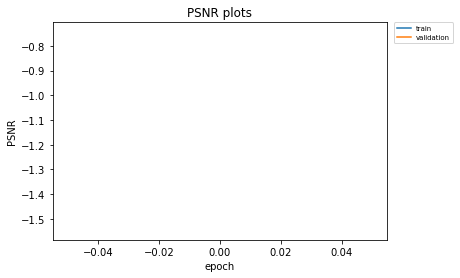

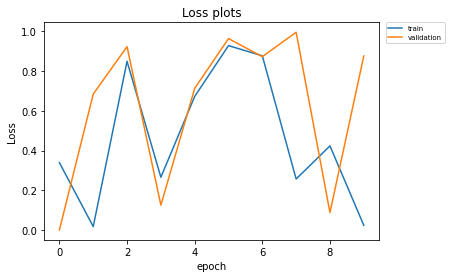

In [22]:
from matplotlib import pyplot as plt



plt.plot(train_psnr_log)
plt.plot(valid_psnr_log)
plt.title("PSNR plots")
plt.ylabel("PSNR")
plt.xlabel("epoch")
plt.legend(
    ["train", "validation"],
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize="x-small",
)

plt.savefig(opt.results + "/SRCNN_Model_PSNR.png", bbox_inches="tight", dpi=600)
plt.show()

plt.plot(train_loss_log)
plt.plot(valid_loss_log)
plt.title("Loss plots")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(
    ["train", "validation"],
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize="x-small",
)

plt.savefig(opt.results + "/SRCNN_Model_MSE_loss.png", bbox_inches="tight", dpi=600)
plt.show()